In [6]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from sbcbinaryformat import Streamer, Writer
from scipy import signal as sg

ana_path = "../LAr10Ana/"
sys.path.insert(0, ana_path)

from GetEvent import GetEvent

%matplotlib inline

In [16]:
run = "/exp/e961/data/SBC-25-daqdata/20260202_6.tar"
event = 0
data = GetEvent(run, event, strictMode=False, lazy_load_scintillation=False)
rc = data["run_control"]
scint = data["scintillation"]
data.keys()

dict_keys(['acoustics', 'scintillation', 'cam', 'event_info', 'plc', 'digiscope', 'slow_daq', 'run_info', 'run_control'])

In [29]:
decimation = rc["caen"]["global"]["decimation"]
post_trig = rc["caen"]["global"]["post_trig"]
enabled_channel_count = [np.sum(rc["caen"][f"group{g}"]["acq_mask"]) for g in range(4)]
range_v = [2 if rc["caen"][f"group{g}"]["range"]=="2 Vpp" else 0.5 for g in range(4)]
range_v = np.concatenate([np.full(count, val) for count, val in zip(enabled_channel_count, range_v)])[:,np.newaxis]
offset = [rc["caen"][f"group{g}"]["offset"] for g in range(4)]
offset = np.concatenate([np.full(count, val) for count, val in zip(enabled_channel_count, offset)])[:,np.newaxis]

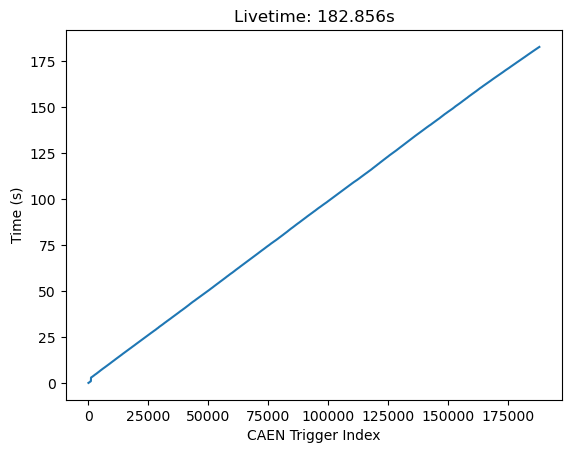

In [19]:
timestamps = scint["TriggerTimeTag"].astype(np.int64)
wraps_ind = sg.find_peaks(np.abs(np.diff(timestamps)), height=2**30)[0]
sample_rate = 62.5e6
for i in wraps_ind:
    timestamps[i+1:]+=2**31
timestamps = (timestamps - timestamps[0])/(2*sample_rate)
livetime = timestamps[-1]
plt.plot(timestamps)
plt.title(f"Livetime: {livetime:.3f}s")
plt.ylabel("Time (s)")
plt.xlabel("CAEN Trigger Index")
plt.show()

Text(0, 0.5, 'Amplitude (V)')

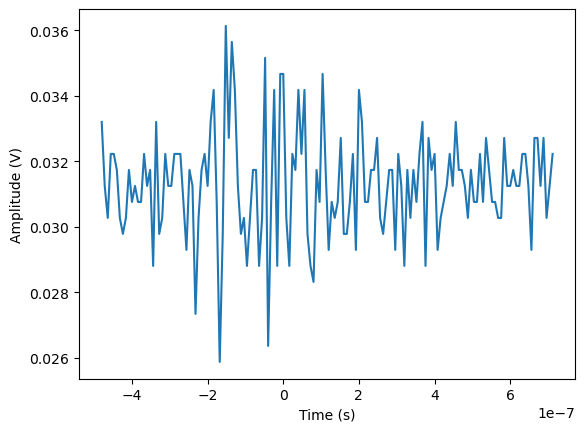

In [30]:
waveform_phys = (scint["Waveforms"].astype("f") - offset/2**4) / 2**12 * range_v
length = waveform_phys.shape[2]
tick = 8e-9
time = (np.array(range(length)) - length*(1-post_trig/100)) * tick
plt.plot(time, waveform_phys[0,0])
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (V)")

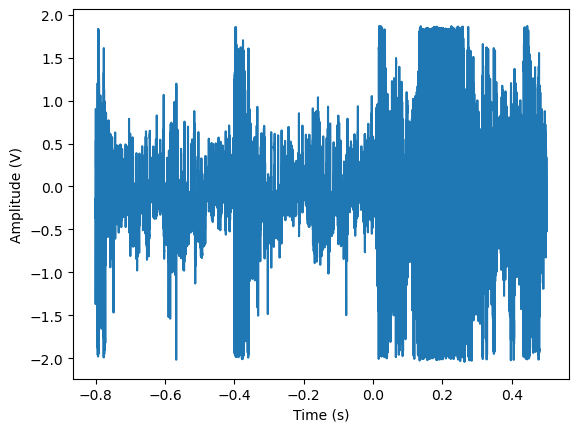

In [5]:
acous = data["acoustics"]
acous_phys = (acous["Waveforms"] - acous["DCOffset"][:,:,np.newaxis]) / 2**16 * acous["Range"][:,:,np.newaxis] / 1000
length = acous["Waveforms"].shape[2] 
time = (np.array(range(length)) / acous["sample_rate"] - rc["acous"]["pre_trig_len"])
plt.plot(time, acous_phys[0,5])
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (V)")
plt.show()

In [9]:
print(rc["caen"])

{'global': {'enabled': False, 'data_path': '/mnt/T9SSD/rc-data/current_event/', 'model': 'DT5740D', 'link': 0, 'connection': 'USB', 'evs_per_read': 500, 'rec_length': 150, 'post_trig': 60, 'trig_in_as_gate': False, 'decimation': 4, 'overlap_en': False, 'memory_full': 'One Buf Free', 'counting_mode': 'All', 'polarity': 'Falling', 'majority_level': 1, 'majority_window': 15, 'clock_source': 'Internal', 'acq_mode': 'SW CTRL', 'io_level': 'TTL', 'ext_trig': 'DISABLED', 'sw_trig': 'DISABLED', 'ch_trig': 'ACQ_AND_EXTOUT'}, 'group0': {'enabled': True, 'threshold': 2000, 'offset': 32768, 'range': '2 Vpp', 'name': ['1-01', '1-02', '1-03', '1-04', '1-05', '1-06', '1-07', '1-08'], 'trig_mask': [True, True, True, True, True, True, True, True], 'acq_mask': [True, True, True, True, True, True, True, True], 'plot_mask': [True, True, True, True, True, True, True, True], 'ch_offset': [4, 0, 5, 3, 7, 6, 8, 8]}, 'group1': {'enabled': True, 'threshold': 2000, 'offset': 32640, 'range': '2 Vpp', 'name': ['1-

In [23]:
enabled_channel_count = [np.sum(rc["caen"][f"group{g}"]["acq_mask"]) for g in range(4)]
range_v = [2 if rc["caen"][f"group{g}"]["range"]=="2 Vpp" else 0.5 for g in range(4)]
range_v = np.concatenate([np.full(count, val) for count, val in zip(enabled_channel_count, range_v)])
offset = [rc["caen"][f"group{g}"]["offset"] for g in range(4)]
offset = np.concatenate([np.full(count, val) for count, val in zip(enabled_channel_count, offset)])